다음은 EM 알고리즘 기반 GMM(Gaussian Mixture Model) 스크래치 구현 코드입니다. Python과 NumPy만을 사용하며, sklearn 없이 직접 구현합니다.

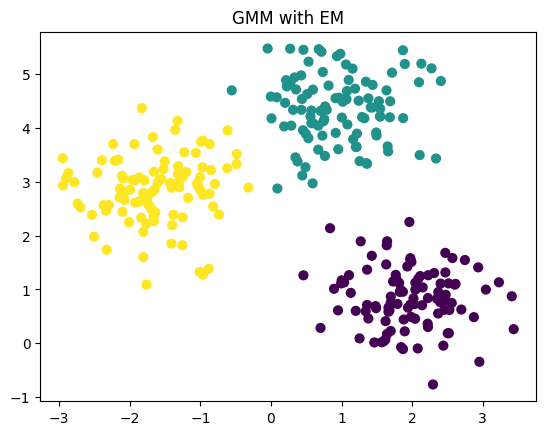

In [10]:
import numpy as np
from scipy.stats import multivariate_normal

class GMM:
    def __init__(self, n_components=2, max_iter=100, tol=1e-6):
        self.k = n_components
        self.max_iter = max_iter
        self.tol = tol

    def initialize_parameters(self, X):
        n_samples, n_features = X.shape
        rng = np.random.default_rng()
        self.pi = np.ones(self.k) / self.k  # Mixing weights
        self.mu = X[rng.choice(n_samples, self.k, replace=False)]  # Random means
        self.sigma = np.array([np.cov(X, rowvar=False) for _ in range(self.k)])  # Shared cov

    def e_step(self, X):
        n_samples = X.shape[0]
        self.resp = np.zeros((n_samples, self.k))  # Responsibilities

        for i in range(self.k):
            self.resp[:, i] = self.pi[i] * multivariate_normal.pdf(X, self.mu[i], self.sigma[i])
        
        # Normalize responsibilities
        self.resp /= self.resp.sum(axis=1, keepdims=True)

    def m_step(self, X):
        n_samples, n_features = X.shape
        Nk = self.resp.sum(axis=0)  # Effective number of points for each cluster

        for i in range(self.k):
            # Update mean
            self.mu[i] = (self.resp[:, i][:, np.newaxis] * X).sum(axis=0) / Nk[i]
            # Update covariance
            diff = X - self.mu[i]
            self.sigma[i] = (self.resp[:, i][:, np.newaxis, np.newaxis] * np.einsum('ni,nj->nij', diff, diff)).sum(axis=0) / Nk[i]
            # Update mixing weights
            self.pi[i] = Nk[i] / n_samples

    def compute_log_likelihood(self, X):
        ll = 0
        for i in range(self.k):
            ll += self.pi[i] * multivariate_normal.pdf(X, self.mu[i], self.sigma[i])
        return np.sum(np.log(ll))

    def fit(self, X):
        self.initialize_parameters(X)
        self.log_likelihoods = []

        for iteration in range(self.max_iter):
            prev_ll = self.compute_log_likelihood(X)
            self.e_step(X)
            self.m_step(X)
            curr_ll = self.compute_log_likelihood(X)
            self.log_likelihoods.append(curr_ll)

            if abs(curr_ll - prev_ll) < self.tol:
                break

    def predict(self, X):
        self.e_step(X)
        return np.argmax(self.resp, axis=1)
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

X, y_true = make_blobs(n_samples=300, centers=3, cluster_std=0.6, random_state=0)

gmm = GMM(n_components=3)
gmm.fit(X)
y_pred = gmm.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='viridis', s=40)
plt.title("GMM with EM")
plt.show()


각 클러스터 평균:
 [[-0.03940957  0.01060906]
 [ 5.00388127  5.02327101]]
각 클러스터 공분산:
 [[[ 0.85941267  0.24723053]
  [ 0.24723053  0.93113753]]

 [[ 1.45153574 -0.13154263]
  [-0.13154263  1.00698026]]]
클러스터 가중치: [0.39857162 0.60142838]


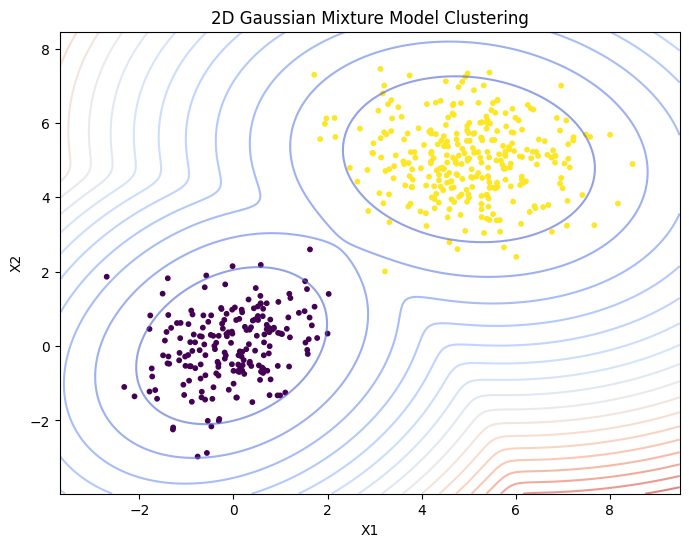

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# 1. 가짜 2차원 데이터 생성
np.random.seed(42)
X1 = np.random.multivariate_normal(mean=[0, 0], cov=[[1, 0.3],[0.3, 1]], size=200)
X2 = np.random.multivariate_normal(mean=[5, 5], cov=[[1.5, -0.2],[-0.2, 1]], size=300)
X = np.vstack([X1, X2])

# 2. GMM 학습 (클러스터 2개로 가정)
gmm = GaussianMixture(n_components=2, covariance_type="full", random_state=42)
gmm.fit(X)

labels = gmm.predict(X)          # 클러스터 할당
probs = gmm.predict_proba(X)     # 소속 확률

# 3. 결과 출력
print("각 클러스터 평균:\n", gmm.means_)
print("각 클러스터 공분산:\n", gmm.covariances_)
print("클러스터 가중치:", gmm.weights_)

# 4. 시각화
plt.figure(figsize=(8,6))
plt.scatter(X[:,0], X[:,1], c=labels, cmap="viridis", s=10)

# GMM 클러스터의 등고선(확률 밀도) 그리기
x = np.linspace(np.min(X[:,0])-1, np.max(X[:,0])+1, 200)
y = np.linspace(np.min(X[:,1])-1, np.max(X[:,1])+1, 200)
Xgrid, Ygrid = np.meshgrid(x, y)
XY = np.array([Xgrid.ravel(), Ygrid.ravel()]).T
Z = -gmm.score_samples(XY)   # 음수 log-likelihood
Z = Z.reshape(Xgrid.shape)

plt.contour(Xgrid, Ygrid, Z, levels=20, cmap="coolwarm", alpha=0.6)
plt.title("2D Gaussian Mixture Model Clustering")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

